<font color=#368BC1 size=6.5px><h1> <center>EngPredicts: A Predictive Maintainence Program Designed to Estimate Remaining Useful Life of a Jet Engine + More </center></h1></font>
<img src="IOT_Predict_Maint.png">

Imagine that you could predict the next time that your car's "check engine" light came on. Or the next time an appliance in your home needs to be replaced. As sensors become cheaper and find themselves onto everyday machines, an opportunity arises for an application that can predict the remaining useful life (RUL) based on the sensor outputs.

Knowing when machinery requires maintenance ahead of time is very valuable knowledge. For example, if you know that your check engine light is about to turn on in 5 days, you probably wouldn't schedule a long road trip this upcoming weekend. Alternatively, if you know that your refrigerator is going to break in 30 days, you can schedule a repair man to come by in 3 weeks.

An accurate RUL prediction is vital, otherwise, knowing an inaccurate RUL is as useless as not knowing at all. If the model predicts too high of a RUL, we may schedule the maintenance too late and risk a breakdown. If the model predicts too low of a RUL, we lose money by scheduling maintenance too soon and not getting the most out of our equipment.

EngPredicts is a product designed to tackle the problem of predictive maintenance. EngPredicts was inspired by predicting Jet Engine Remaining Useful Life but can be extended to any machine or appliance that collects data from a series of sensors. The product has capability to make predictions on RUL, even if the appliance or machine changes conditions. The product takes in training data in the form of sensor data and cycles remaining before failure. Then, given a training set of sensor values, EngPredicts will predict the remaining useful life. 

<font color=#368BC1 size=5pt><h1>What is the Dataset?</h1></font>

The project used the data set from the Prognostics and Health Management (PHM) data competition at PHM’08 found [here](https://www.kaggle.com/behrad3d/nasa-cmaps). It is a dataset generated by NASA using an engine simulation program called C-MAPSS. The training set includes data for 100 engines. The data starts at a random point around 100-300 cycles before failure and continues until the failure occurs.
 
 The data output for each cycle includes the following:
  - Altitude
  - Speed (Mach Number)
  - Throttle %
  - 21 sensor values
  
  
In the 1st and 3rd data sets, the sensor values are collected at a constant altitude, speed, and throttle. In the  2nd and 4th data set, the sensor values are collected at 6 different combinations of altitude, speed, and throttle. Note, that as the operating condition of the engine changes, the nominal sensor value changes as well. In the 1st and 2nd data sets, only one type of failure occurs, while in the 3rd and 4th data sets, 2 types of failures occur. Thus, the approach must be adaptable enough to handle both different operating conditions and different failure types. Finally, NASA has added random noise to the sensor data to emulate a real life situation. 


The photo above indicates where some of the sensors lie in  a Jet engine. In our analysis, the location and the type of sensor does not matter. We will down select to the most important sensors.

<img src="engine_sensors.png">

<font color=#368BC1 size=5pt><h1>How did we approach the problem?</h1></font>

At a high level, there are 4 problems to solve so we can successfully predict the Remaining Useful Life (RUL) of our jet engine:


1. Accounting for different operating conditions
2. Accounting for the sensor noise and picking the useful sensors
3. Developing a model between the sensors and the RUL
4. Using the models to predict the RUL for the testing data engines

Some of these problems are easily solved while others take quite a bit of work. Nonetheless, we will go over all of them now and then show off the code.

<font color=Black><h3>Accounting for different operating conditions</h3></font>

As discussed above, in some training and testing sets, the data will be given at different flight conditions. This is accommodated by normalizing the sensor data at each operating condition by dividing the sensor values by their value of the first instance of the operating condition. Then, the sensor data is multiplied by the first instance of the baseline operating condition to get all sensor values in terms of a baseline condition. This is handled by the SLS_preprocess function displayed below.

<font color=Black><h3>Accounting for the sensor noise and picking the useful sensors</h3></font>

Eliminating the sensor noise is quite easy. If the noise distribution is assumed to be normal, a simple moving average should eliminate most of the noise. The "rolling_mean_window" variable is used as an input to see how changing the rolling mean window will effect the RUL prediction. There is a tradeoff between getting a less noisy signal and eliminating some of the data at the beginning. To pick out the useful sensors, the percent measured change for each sensor for all engines is calculated. A high percent measured change indicates that the sensor output changes alot across the life of the engine. This would indicate the this sensor correlates well with RUL. Sensors with an average percent change of greater than 1 are considered. Also, sensors that have a high amount of variance, standard deviation of the percent measured change greater than 0.75, are eliminated. The figures below show the values of Sensor 3 and Sensor 20 as a function of RUL.


<table><tr><td><img src="s3.png" width="500" height="500"></td><td><img src="s21.png" width="500" height="500"></td></tr></table>

<font color=Black><h3>Developing a model between the sensors and the RUL</h3></font>

This step was the most research intensive of the process. Many papers and articles have been written outlining the process of modeling RUL using sensor data inputs. The consensus of these papers and articles is to use a linear regression to map the Health Indicator as a function of sensor data [1]. This can be achieved by the following formula: 

$y=QT$ <br>
$T=(Q_{off}Q_{off}^{T})^{-1}Q_{off} S_{off}$

Where y is the Health Indicator, Q is a 1xd vector of sensor values, $S_{off}=[S_{0}, S_{1}]$ and $Q_{off}=[Q_{0}, Q_{1}]$. The model T, is unique for each testing engine. $S_{0}$ is a 1xM matrix of zeros, $S_{1}$ is a 1xN matrix of ones, $Q_{0}$ is a Mxd matrix of unhealthy engine sensor values and $Q_{1}$ is a Nxd matrix of healthy engine sensor values [1]. The day at which a engine is healthy, variable: max_day_cutoff or unhealthy, variable: min_day_cutoff, is a user input and will be varied until the best fit is achieved. 


This procedure is caried out for each operational cycle, for each engine that is older than max_day_cutoff. Then the HI is plotted as a function of RUL. This is insufficient and thus, an exponential, form shown below, is fit to this relationship using sklearn.

$HI=a*e^{b*RUL}-a$

An exponential of this form ensures that when RUL is 0, the HI is 0. The HI generated from the sensor values, and the exponential fit curve, are shown below, as a function of RUL.

<img src="HI_plot.png" width="600" height="600">


Note, there are ~20 models like the one above for each training set, thus there will be a vector T and a set of exponential curve coefficients for each. The final step of the project is developing a process of using these models to predict the RUL for the test data set.

<font color=Black><h3>Using the models to predict the RUL for the testing data engines</h3></font>

The test data is read into the code using the same methods as above. In our implementation, only the last cycle of each engine is considered. The sensor data on this cycle is converted into a set of HI values using the set of T matrices. These HI are then turned into RUL using the respective exponential curve fits. In the end, we will end up with a vector of predicted RUL values for each test engine. We could simply average the values in the vector to get a final RUL prediction, but that's no fun. Instead, we took the innovative approach of measuring the distance between the sensor readings the "model" engine and the "test" engine. Then, we took the average of the RUL for the 5 models with the lowest distance. This step takes into account that the engines start off with a random amount of degradation. By taking the lowest distance between the sensor values, we can prioritize using prediction models with similar amounts of degradation as our test engine.


<font color=#368BC1 size=5pt><h1>The Code!</h1></font>
The code used in the project is shown below. Scroll to the bottom to see the results! 


In [1]:
import math
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def SLS_preprocess(inital_data):
    inital_data["alt"]=inital_data["alt"].round(0)
    inital_data["MN"]=inital_data["MN"].round(2)
    inital_data["TRL"]=inital_data["TRL"].round(0)
    inital_data['cond']=inital_data["MN"]*inital_data["TRL"]*inital_data["alt"]

    unique_engines=inital_data['engine_num'].unique();
    df_out=pd.DataFrame(columns=inital_data.columns)
    for i in unique_engines: 
        temp_df=inital_data.iloc[inital_data.index[inital_data['engine_num'] == i].tolist(),:]
        temp_df = temp_df.reset_index(drop=True)  
        sL_factors=temp_df.iloc[temp_df.index[temp_df['cond'] == 0.0].tolist(),:].to_numpy()[0,5:-1]
        cond_factors_array=[]
        unique_conditions=temp_df['cond'].unique();
        for j in unique_conditions:
            cond_factors=temp_df.iloc[temp_df.index[temp_df['cond'] == j].tolist(),:].to_numpy()[0,5:-1]
            temp_df.iloc[temp_df.index[temp_df['cond'] == j].tolist(),5:-1]=np.true_divide(temp_df.iloc[temp_df.index[temp_df['cond'] == j].tolist(),:].to_numpy()[:,5:-1],cond_factors)*sL_factors
        df_out=df_out.append(temp_df, ignore_index=True)
    return   df_out

def predict_health(training_file,test_file,actual_health_file,max_day_cutoff, min_day_cutoff, rolling_mean ):
    names_cols=["engine_num","Cycle", "alt", "MN", "TRL","s1","s2","s3", "s4","s5","s6", "s7","s8","s9","s10", "s11", "s12", "s13", "s14", "s15","s16", "s17", "s18", "s19", "s20", "s21"]
    sensor_names=["s1","s2","s3", "s4","s5","s6", "s7","s8","s9","s10", "s11", "s12", "s13", "s14", "s15","s16", "s17", "s18", "s19", "s20", "s21"]
    inital_data=pd.read_csv(training_file,delim_whitespace=True,names=names_cols)


    inital_data=SLS_preprocess(inital_data)


    unique_engines=inital_data['engine_num'].unique();

    new_df=inital_data.copy();
    new_df['RUL']=0;

    per_degre_array=np.zeros((len(unique_engines),21))

    for i in unique_engines:

        temp_df=new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),:]
        start_life=len(temp_df);
        RUL_vector=np.linspace(-1*(start_life-1),0,start_life)
        new_df.loc[new_df.index[new_df['engine_num'] == i].tolist(),'RUL'] = RUL_vector;
        new_df.loc[new_df.index[new_df['engine_num'] == i].tolist(),5:26] = new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),5:26].rolling(window=rolling_mean).mean()

        percent_degre=abs((1-temp_df.iloc[-1,5:26]/temp_df.iloc[0,5:26])*100).tolist()
        per_degre_array[i-1,:]=percent_degre


    sensor_mean_og=per_degre_array.mean(axis=0);
    sensor_std= per_degre_array.std(axis=0)[sensor_mean_og>1]
    sensor_mean=sensor_mean_og[sensor_mean_og>1]
    sensor_mean=sensor_mean[sensor_std<0.75]

    valuable_sensors_index=[]
    for i in sensor_mean:
        valuable_sensors_index.append(np.where(sensor_mean_og==i)[0][0].tolist())

    T = [sensor_names[i] for i in valuable_sensors_index]    


    new_df = new_df.dropna()
    new_df = new_df.reset_index(drop=True)

    T_array=[];
    popt_array=[];


    df_usefulEngines=pd.DataFrame(columns=new_df.columns)
    df_usefulEngines['HI']=0;

    def func(x, a, b):

        b_x=b*x;
        for i in range(len(b_x)):
            if(b_x[i]>700):
                b_x[i]=700
        return a*np.exp(b_x)-a




    for i in unique_engines: 
        temp_df=new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),:]
        temp_df = temp_df.reset_index(drop=True)
        start_life=len(temp_df);
        index_start=start_life-max_day_cutoff;
        index_end=start_life-min_day_cutoff;
        if(start_life>max_day_cutoff):
            Q1=temp_df.loc[0:index_start,T].to_numpy()
            Q0=temp_df.loc[index_end:,T].to_numpy()
            S0=np.zeros((1,len(Q0)))
            S1=np.ones((1,len(Q1)))

            S_off=np.transpose(np.append(S0,S1))
            S_off=np.reshape(S_off,(len(S_off),1))
            Q_off=np.transpose(np.append(Q0,Q1,axis=0))

            T_vector=np.matmul(np.matmul(inv(np.matmul((Q_off),np.transpose(Q_off))),(Q_off)),S_off)

            HI=[]
            for i in range(len(temp_df)):
                Q=temp_df.loc[i,T].to_numpy()
                Q=np.reshape(Q,(1,len(Q)))
                HI.append(np.matmul(Q,T_vector)[0][0])



            temp_temp_df=pd.DataFrame(HI,columns=['HI'])
            temp_temp_df=temp_temp_df.rolling(window=10).mean()
            temp_df['HI']=temp_temp_df['HI'];
            temp_df = temp_df.dropna()
            temp_df = temp_df.reset_index(drop=True) 

            popt, pcov = curve_fit(func, temp_df['RUL'].to_numpy(), temp_df['HI'].to_numpy(), maxfev=10000)

            popt_array.append(popt)

            T_array.append(T_vector)

            df_usefulEngines=df_usefulEngines.append(temp_df)


    test_data=pd.read_csv(test_file,delim_whitespace=True,names=names_cols)

    test_data=SLS_preprocess(test_data)

    unique_test_engines=test_data['engine_num'].unique();

    new_df=test_data.copy();


    def rev_func(x, a, b):
        if(((x+a)/a)<0):
            return 0
        else:
            return np.log(((x+a)/a))/b


    for i in unique_engines:

        temp_df=new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),:]
        start_life=len(temp_df);
        RUL_vector=np.linspace(-1*(start_life-1),0,start_life)
        new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),5:26] = new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),5:26].rolling(window=rolling_mean).mean()


    new_df = new_df.dropna()
    new_df = new_df.reset_index(drop=True)


    RUL_array=[]
    sensor_distance_array=[]

    unique_useful_engines=df_usefulEngines['engine_num'].unique();

    for i in unique_test_engines:
        temp_df=new_df.iloc[new_df.index[new_df['engine_num'] == i].tolist(),:]
        RUL_vector=[]
        sensor_distance_vector=[]
        for j in range(len(T_array)):
            Q=temp_df.iloc[-1,:]
            Q=Q.loc[T].to_numpy()
            HI=np.matmul(Q, T_array[j])



            if(HI<0):
                 RUL=0;
            else:
                popt=popt_array[j]
                RUL=rev_func(HI[0], *popt)

            if(abs(RUL)>max_day_cutoff):
                RUL=-1*max_day_cutoff;
            RUL_vector.append(RUL)

            other_temp_df=df_usefulEngines.iloc[df_usefulEngines.index[df_usefulEngines['engine_num'] == unique_useful_engines[j]].tolist(),:]
            sensors_useful_engines=other_temp_df.loc[other_temp_df.index[other_temp_df['RUL'] == round(RUL)].tolist(),T].to_numpy()
            if(len(sensors_useful_engines)==0):
                sensors_useful_engines=other_temp_df.loc[0,T].to_numpy()
            distance=sum((Q-sensors_useful_engines[0])**2)

            sensor_distance_vector.append(distance)

        RUL_array.append(RUL_vector)
        sensor_distance_array.append(sensor_distance_vector)

    RUL_array=np.array(RUL_array)
    sensor_distance_array=np.array(sensor_distance_array)


    best_engines=np.argsort(sensor_distance_array,axis=1)[:,:4]

    # final_RUL=(np.nanmean(RUL_array, axis=1))


    final_RUL=np.zeros((len(best_engines),1))

    for i in range(len(best_engines)):
        final_RUL[i,0]=np.nanmean(RUL_array[i,best_engines[i,:]])

    final_RUL=abs(np.around(np.resize(final_RUL,(len(final_RUL),1)),0))
    test_actual_data=pd.read_csv(actual_health_file,delim_whitespace=True,names=['RUL']).to_numpy()

    d=final_RUL-test_actual_data;


    score=0;
    for i in d:
        if(i<0):
            score=score+math.exp(-i/10)-1
        else:
            score=score+math.exp(i/13)-1

    
    rmse = math.sqrt(((test_actual_data - final_RUL) ** 2).sum()/test_actual_data.shape[0]) 
    print('RMSE: ' + str(round(rmse,0)))
    
    
    i=test_actual_data - final_RUL;
    overpredictions=sum(i<0)
    
    print('Over Predictions: ' + str((overpredictions[0])))
    underpredictions=sum(i>0)
    print('Under Predictions: ' + str((underpredictions[0])))
    
    correctpredictions=sum(i==0)
    print('Correct Predictions: ' + str((correctpredictions[0])))
    
    
    return score, rmse, final_RUL, test_actual_data


<font color=#368BC1 size=5pt><h1>Single failure mode at a single flight condition</h1></font>

The first test run is the single failure mode at a single flight condition data set:

In [2]:
max_day_cutoff=200;
min_day_cutoff=10;
rolling_mean_window=9;

training_file_name='train_FD001.txt'
testing_file_name='test_FD001.txt'
actual_data_file_name='RUL_FD001.txt'

RMSE: 33.0
Over Predictions: 52
Under Predictions: 48
Correct Predictions: 0


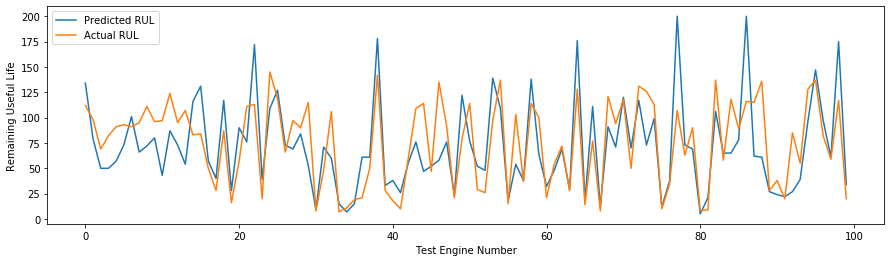

In [3]:
score, rmse, final_RUL, test_actual_data = predict_health(training_file_name,testing_file_name,actual_data_file_name,max_day_cutoff, min_day_cutoff, rolling_mean_window );


plt.figure(figsize=(15,4))
plt.plot(final_RUL,label='Predicted RUL')
plt.plot(test_actual_data, label='Actual RUL')
plt.legend()
plt.xlabel('Test Engine Number')
plt.ylabel('Remaining Useful Life')
plt.show()



From above, the RMSE for this test is 33. This is quite good considering that the RUL are whole numbers and their magnitude is quite large. We show an even mix between under predictions and overpredictions, however when analyzing the graph, we can see that generally, we do a very good job at predicting the lower RUL engines as compared to the higher RUL engines. This makes sense because of the exponential nature of the model. A small deviation in health index will create a large jump in RUL causing us to miss big. At really low health indices, a small deviation in health index does not cause a large jump in the RUL. Even though we are unable to predict accurate RUL 100 days out, an accurate 50 day prediction is more than enough to schedule maintenance.

<font color=#368BC1 size=5pt><h1>Multiple failures mode at a single flight condition</h1></font>

The next test run is the multiple failure mode at a single flight condition data set:

In [4]:
max_day_cutoff=200;
min_day_cutoff=10;
rolling_mean_window=9;

training_file_name='train_FD003.txt'
testing_file_name='test_FD003.txt'
actual_data_file_name='RUL_FD003.txt'

RMSE: 47.0
Over Predictions: 78
Under Predictions: 22
Correct Predictions: 0


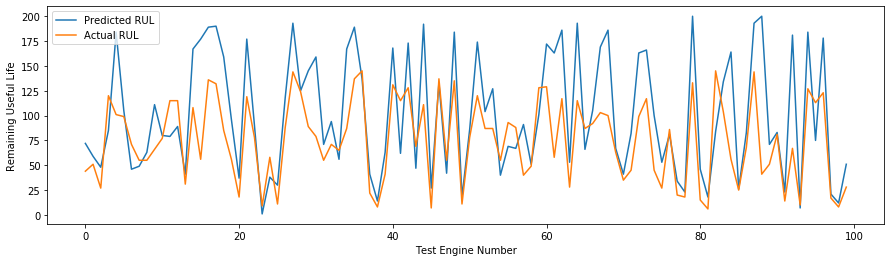

In [5]:
score, rmse, final_RUL, test_actual_data = predict_health(training_file_name,testing_file_name,actual_data_file_name,max_day_cutoff, min_day_cutoff, rolling_mean_window );

plt.figure(figsize=(15,4))
plt.plot(final_RUL,label='Predicted RUL')
plt.plot(test_actual_data, label='Actual RUL')
plt.legend()
plt.xlabel('Test Engine Number')
plt.ylabel('Remaining Useful Life')
plt.show()

As we go to a more complicated test, the RMSE increases as expected. Still, similar to the case above, our model seems to do a very good job at predicting the low RUL engines but misses at the high RUL engines. In the future, a different approach could be considered to improve the high RUL prediction.

<font color=#368BC1 size=5pt><h1>Single failure mode at a multiple flight conditions</h1></font>

The third test run is the single failure mode at multiple flight conditions data set:

In [6]:
max_day_cutoff=200;
min_day_cutoff=10;
rolling_mean_window=9;

training_file_name='train_FD002.txt'
testing_file_name='test_FD002.txt'
actual_data_file_name='RUL_FD002.txt'

RMSE: 55.0
Over Predictions: 195
Under Predictions: 64
Correct Predictions: 0


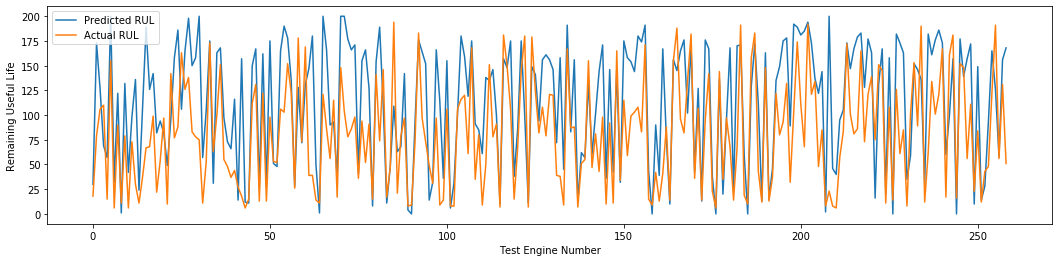

In [7]:
score, rmse, final_RUL, test_actual_data = predict_health(training_file_name,testing_file_name,actual_data_file_name,max_day_cutoff, min_day_cutoff, rolling_mean_window );



plt.figure(figsize=(18,4))
plt.plot(final_RUL,label='Predicted RUL')
plt.plot(test_actual_data, label='Actual RUL')
plt.legend()
plt.xlabel('Test Engine Number')
plt.ylabel('Remaining Useful Life')
plt.show()


Again, the RMSE slightly increases due to the higher complexity test case. As discussed multiple times, the model continues to miss on predicting high RUL engines. Nonetheless, our model is capable enough at dealing with different flight conditions which shows alot of promise.

<font color=#368BC1 size=5pt><h1>Multiple failure modes at a multiple flight conditions</h1></font>

Finally, the most complicated test is run, the multiple failure modea at multiple flight conditions data set:

In [8]:
max_day_cutoff=200;
min_day_cutoff=10;
rolling_mean_window=9;

training_file_name='train_FD004.txt'
testing_file_name='test_FD004.txt'
actual_data_file_name='RUL_FD004.txt'

RMSE: 48.0
Over Predictions: 90
Under Predictions: 150
Correct Predictions: 8


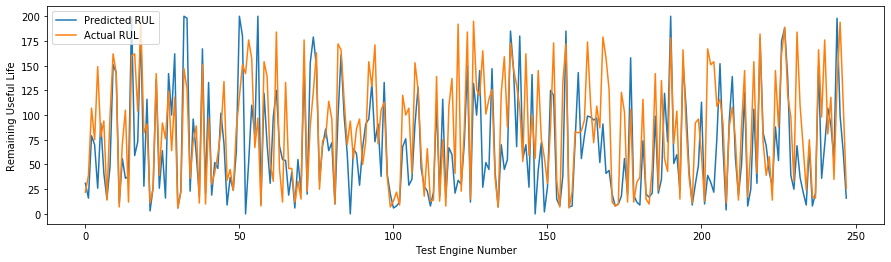

In [9]:
score, rmse, final_RUL, test_actual_data = predict_health(training_file_name,testing_file_name,actual_data_file_name,max_day_cutoff, min_day_cutoff, rolling_mean_window );



plt.figure(figsize=(15,4))
plt.plot(final_RUL,label='Predicted RUL')
plt.plot(test_actual_data, label='Actual RUL')
plt.legend()
plt.xlabel('Test Engine Number')
plt.ylabel('Remaining Useful Life')
plt.show()


Interestingly, our RMSE actually decreases between this case and the third case. Also, the trend has now reversed and there are more under predictions than there are over predictions.

## Conclusion

Overall, the approach outlined above does a sufficient job at predicting the Jet Engine Remaining Useful Life. Our model can accurately predict the RUL of low health engines, however, improvement needs to be made to accurately predict the RUL of high health engines. Next steps for this project would be to test different machines and appliances to see if the model can be extended beyond its initial use.

[1] B. Zhang, K. Zheng, Q. Huang, S. Feng, S. Zhou and Y. Zhang, "Aircraft Engine Prognostics Based on Informative Sensor Selection and Adaptive Degradation Modeling with Functional Principal Component Analysis", Sensors, vol. 20, no. 3, p. 920, 2020. Available: 10.3390/s20030920.